In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
from itertools import combinations
import collections
from CleanedCode.functions import*

In [3]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts in PDF
mpl.rcParams['ps.fonttype'] = 42   # Use TrueType fonts in PS

In [4]:
methods = ['epsilon','ts','ucb','sh']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound','SuccessiveHalving']))
colormap = dict(zip(methods, ['#8ac926','#ffca3a','#ff595e','#669bbc']))
plt.rcParams.update({'font.size': 14})

First

In [11]:
IfStationary=True
length_scale=1
K=5
num_points=15
actionspace = np.linspace(0,2,num_points)
fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary,actionspace=actionspace)
kernel=fun.kernel
output_ep=[]
output_sh=[]
for ignore in range(50):
    fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary,actionspace=actionspace,kernel=kernel)
    output_ep+=[fun.test(fun.subset)]
    arm_seq, pull_seq=fun.run_sh_sequence()
    output_sh+=[[fun.test(arm) for arm in arm_seq]]

In [52]:
pull_seq

[3003,
 6005,
 9005,
 12005,
 14997,
 18066,
 21148,
 24230,
 27310,
 30390,
 33472,
 36555]

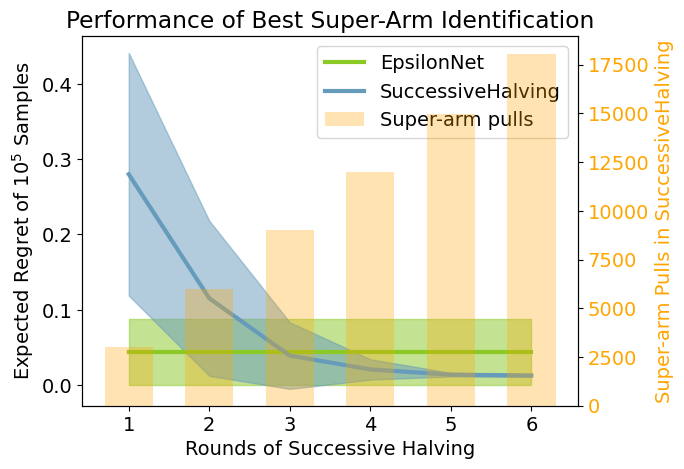

In [12]:
fig, ax1 = plt.subplots()

# X-axis: time periods
window_length=6
periods = np.arange(1, window_length + 1)

# ep
mean,std=compute_meanstd(output_ep)
# Plot mean and shaded ±1 std region
ax1.plot(periods, [mean]*len(periods), label=methodnames['epsilon'], color=colormap['epsilon'],linewidth=3)
ax1.fill_between(periods, [mean-std]*len(periods), [mean+std]*len(periods), color=colormap['epsilon'], alpha=0.5)

# sh
mean,std=compute_meanstd(output_sh)
mean=mean[0:window_length]
std=std[0:window_length]

# Plot mean and shaded ±1 std region
ax1.plot(periods, mean, label=methodnames['sh'], color=colormap['sh'],linewidth=3)
ax1.fill_between(periods, mean - std, mean + std, color=colormap['sh'], alpha=0.5)

ax1.set_ylabel(r"Expected Regret of $10^5$ Samples")
ax1.tick_params(axis='y')

# Create a secondary y-axis for the bars
ax2 = ax1.twinx()
ax2.bar(periods, pull_seq[0:window_length], label='Super-arm pulls',
        color='orange', alpha=0.3, width=0.6)
ax2.set_ylabel('Super-arm Pulls in SuccessiveHalving', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Get handles and labels from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine them and add one legend to ax1
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Shared x-axis
ax1.set_xlabel('Rounds of Successive Halving')
plt.title('Performance of Best Super-Arm Identification')
# plt.grid(True)
plt.savefig("RKHS_BAI.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

Second

In [27]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.5,1,1.5,2,2.5,3,4] 
K=5
for length_scale in length_range:
    fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary)
    kernel=fun.kernel
    for ignore in range(50):
        fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary,kernel=kernel)
        output=fun.test(fun.subset)
        sh=fun.test(fun.run_sh(budget=37000))
        ucb=fun.test(fun.run_ucb(time_steps=3000))
        ts=fun.test(fun.run_ts(time_steps=3000))
        row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
        row_sh=pd.Series({'EmpiricialRegret':sh,'length_scale':length_scale,'K':K,'method':'sh'})
        row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
        row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
        report = pd.concat([report,row.to_frame().T,row_sh.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)
        # report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

In [13]:
# report.to_csv('report_rbf.csv',index=None)
report=pd.read_csv('report_rbf.csv')
length_range=[0.5,1,1.5,2,2.5,3,4] 

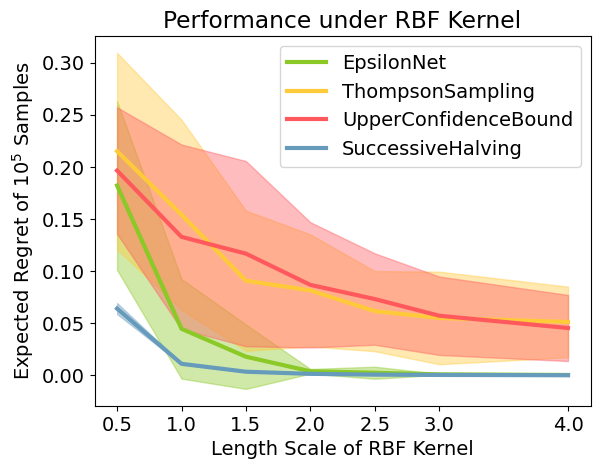

In [14]:
fig, ax = plt.subplots()  # (rows, cols) #figsize=(12,4)
K=5

for m in methods:
    dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[l][K][m] for l in length_range])
    dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
    std=np.array([dfstd[l][K][m] for l in length_range])
    ax.plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=3)
    ax.fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.4)

# axes[i].set_ylim([-0.05,0.5])
ax.set_title('Performance under RBF Kernel') #"K={} out of 15 Actions".format(krange[i])
ax.set_xlabel("Length Scale of RBF Kernel")
ax.set_xticks(length_range)
ax.set_ylabel(r"Expected Regret of $10^5$ Samples")
ax.legend()
# # Move the left spine (axis line) to the right
# ax.yaxis.tick_right()  # Move ticks to the right
# ax.yaxis.set_label_position("right")  # Move the label to the right
plt.savefig("RKHS_RBF.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

Third

In [15]:
num_points=1000
gibbs=gibbsmatrix(num_points=num_points)
actionspace=gibbs.actionspace
kernel=gibbs.kernel
batch_size=5000
all_counts = collections.Counter()
# Run fun.subset() many times and update the counts
fun=GPfunctions_Epsilon(K=batch_size,actionspace=actionspace,kernel=kernel)
indices = fun.subset  # Should return a subset (e.g., list or set) of indices
all_counts.update(indices)

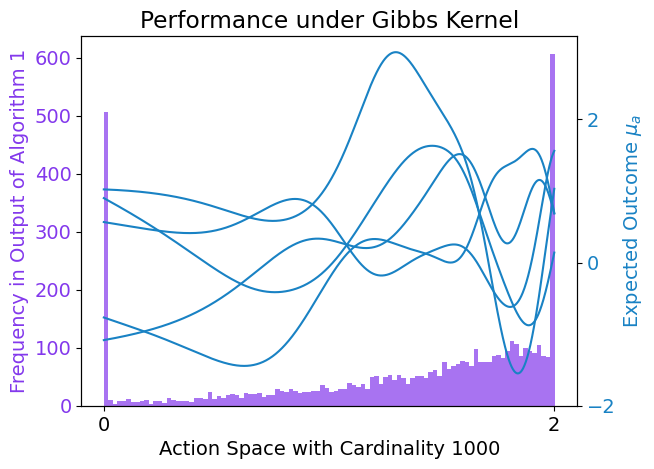

In [16]:
fig, ax1 = plt.subplots()

# First plot (left y-axis)
color1 = '#8338ec'

# Group indices into one bin
bin_size = 10
num_bins = num_points // bin_size
grouped_histogram = [sum(all_counts[i] for i in range(b * bin_size, (b + 1) * bin_size)) for b in range(num_bins)]
# Plot the grouped histogram
ax1.bar([b * bin_size + bin_size/2  for b in range(num_bins)], grouped_histogram, width=bin_size,alpha=0.7,color=color1)
ax1.set_xlabel('Action Space with Cardinality {}'.format(num_points))
ax1.set_xticks([0,999])
ax1.set_xticklabels([0,2])
ax1.set_ylabel('Frequency in Output of Algorithm 1', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title('Performance under Gibbs Kernel')

# Second y-axis
ax2 = ax1.twinx()
color2 = '#1982c4' #"#2a9d8f"
ax2.set_ylabel(r'Expected Outcome $\mu_a$', color=color2)
batch_size=5
fun=GPfunctions_Epsilon(K=1,actionspace=actionspace,kernel=kernel)
fun_samples=fun.samples(size=batch_size)
for i in range(batch_size):
    ax2.plot([*range(num_points)],fun_samples[i,:],color=color2)
ax2.set_yticks([2, 0, -2])  # set the tick positions
ax2.tick_params(axis='y', labelcolor=color2)
plt.savefig("RKHS_Gibbs.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)